In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)


import scipy.interpolate as interp
#import lalsimulation as lal
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import plot_model
import keras
from keras import metrics
import keras_metrics as km
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers 
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from  IPython import display
from matplotlib import pyplot as plt
import pathlib 
import shutil
import tempfile
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)
#gpu configuration:

gpu_num = 1

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        tf.config.experimental.set_visible_devices(gpus[gpu_num], 'GPU')
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
import warnings

2025-01-03 20:22:52.023237: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-03 20:22:52.066535: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-03 20:22:52.729604: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2 Physical GPUs, 2 Logical GPUs
Visible devices cannot be modified after being initialized


2025-01-03 20:22:54.112932: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46506 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:3b:00.0, compute capability: 8.6
2025-01-03 20:22:54.114746: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46506 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:af:00.0, compute capability: 8.6


In [3]:
import os
file_path = os.path.join('/home/smith26/public_html/el-nseos-mll', 'preprocessing.csv')
df = pd.read_csv(file_path, index_col = 0)
df

m1        m2        l1        l2    gamma0  logp1_cgs    gamma1  \
0      1.704363  0.940013  1.686090  3.498810  2.749811  35.365482  4.163723   
1      0.674195  0.488352  4.630310  5.249203  3.595422  34.654207  3.981949   
2      1.944506  1.625537  2.224806  2.701013  3.520350  35.396764  4.952541   
3      0.582582  0.362044  4.685642  5.651456  2.917128  35.255684  1.149857   
4      2.684166  2.462512  1.709042  1.964290  4.252634  34.932686  3.321473   
...         ...       ...       ...       ...       ...        ...       ...   
49995  1.093111  0.866491  1.965994  2.528221  3.791754  33.440527  4.773079   
49996  0.450100  0.421913  3.340404  4.616534  2.362006  33.940821  2.777913   
49997  1.229125  0.916376  2.503452  3.099723  3.293796  33.026767  4.130634   
49998  0.884386  0.667397  2.974374  5.247997  4.598794  35.306336  3.806648   
49999  2.689961  0.624463  3.588572  4.208695  4.750452  34.792232  4.234088   

       logp2_cgs    gamma2  
0      35.765971  1.138051  
1      34.993765  1.593887  
2      36.017062  1.272790  
3      36.029744  1.967677  
4      35.708051  1.456522  
...          ...       ...  
49995  36.900283  1.091320  
49996  34.595926  1.535013  
49997  34.994576  2.092221  
49998  35.632485  1.049226  
49999  35.206430  1.144645  

[50000 rows x 9 columns]

In [9]:
normeddata = df.copy(deep = True )

In [10]:
def normalizeandwhiten(x):
    gamma0_norm = (x['gamma0'] - 1) / (5 - 1)
    gamma1_norm = (x['gamma1'] - 1) / (5 - 1)
    gamma2_norm = (x['gamma2'] - 1) / (5 - 1)
    #normalizating p values
    logp1_cgs_norm = (x['logp1_cgs'] - 33) / (37 - 33)
    logp2_cgs_norm = (x['logp2_cgs'] - 33) / (37 - 33)
    return gamma0_norm, logp1_cgs_norm, gamma1_norm, logp2_cgs_norm, gamma2_norm
#print(gamma0_norm)
# Call the function and save the normalized values to 'normeddata'
normeddata['gamma0'], normeddata['logp1_cgs'], normeddata['gamma1'], normeddata['logp2_cgs'], normeddata['gamma2'] = normalizeandwhiten(normeddata)



In [11]:
train_dataset = normeddata.sample(frac=0.8, random_state=1)
test_dataset = normeddata.drop(train_dataset.index)

In [12]:
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()

In [13]:
train_copy = train_dataset.copy()
test_copy = test_dataset.copy()

train_label = train_copy.drop(columns = ['m1', 'm2', 'l1', 'l2']) #pandas with gamma0, gamma1, logp1, logp2, gamma2 large training
test_label = test_copy.drop(columns = ['m1', 'm2', 'l1', 'l2']) #pandas with gamma0, gamma1, logp1, logp2, gamma2 small testing

train_features = train_copy.drop(columns = ['gamma0', 'gamma1', 'gamma2', 'logp1_cgs', 'logp2_cgs']) #m1, m2, l1,l2 large
test_features = test_copy.drop(columns = ['gamma0', 'gamma1', 'gamma2', 'logp1_cgs', 'logp2_cgs']) #m1,m2,l1,l2 small

In [4]:
import os
hypertune_results = os.path.join('/home/smith26/public_html/el-nseos-mll/CNN/HypertuningResults', 'cnn_hp_tuning_best_model.keras')
model = tf.keras.models.load_model(hypertune_results)

/home/smith26/anaconda3/envs/tf-gpu/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [5]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 3, 16)          │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 3, 16)          │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1, 42)          │           714 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           215 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,061 (11.96 KB)

 Trainable params: 1,009 (3.94 KB)

 Non-trainable params: 32 (128.00 B)

 Optimizer params: 2,020 (7.89 KB)

In [14]:
test_predictions = model.predict(train_features)

I0000 00:00:1719340894.049585    9435 service.cc:145] XLA service 0x1464b40050a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1719340894.049624    9435 service.cc:153]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
I0000 00:00:1719340894.049628    9435 service.cc:153]   StreamExecutor device (1): NVIDIA RTX A6000, Compute Capability 8.6
2024-06-25 13:41:34.059251: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-25 13:41:34.159804: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 204/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step

I0000 00:00:1719340894.992357    9435 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 686us/step


In [16]:
lab_max = normeddata['gamma0'].max()
lab_min = normeddata['gamma0'].min()
lab_range = lab_max - lab_min
lab_mean = normeddata['gamma0'].mean()
print(lab_max, lab_min, lab_range, lab_mean)

0.99999834196278 7.982410285611863e-05 0.9999185178599239 0.6411786126206468


In [17]:
pred_max = test_predictions[:, [0]].max()
pred_min = test_predictions[:, [0]].min()
pred_range = pred_max - pred_min
pred_mean = test_predictions[:, [0]].mean()
print(pred_max, pred_min, pred_range, pred_mean)

0.73822343 0.45946163 0.2787618 0.64555484


In [18]:
predictions_array_length = 40000
numcols = 10
array_sizes =  np.array([[0] * numcols ] * predictions_array_length,dtype='float64')
predictions = pd.DataFrame(array_sizes)
predictions.columns = [ 'gamma0_norm_predicted', 'logp1_cgs_norm_predicted', 'gamma1_norm_predicted', 'logp2_cgs_norm_predicted', 'gamma2_norm_predicted', 'gamma0_predicted', 'logp1_cgs_predicted', 'gamma1_predicted','logp2_cgs_predicted', 'gamma2_predicted']


# In[ ]:


predictions['gamma0_norm_predicted'] = test_predictions[:, [0]]
predictions['logp1_cgs_norm_predicted'] = test_predictions[:, [1]]
predictions['gamma1_norm_predicted'] = test_predictions[:, [2]]
predictions['logp2_cgs_norm_predicted'] = test_predictions[:, [3]]
predictions['gamma2_norm_predicted'] = test_predictions[:, [4]]
predictions


# In[ ]:


predictions['gamma0_predicted'] = test_predictions[:, [0]] * (5 - 1) + 1
predictions['logp1_cgs_predicted'] = test_predictions[:, [1]] *  (37 - 33) + 33
predictions['gamma1_predicted'] = test_predictions[:, [2]] * (5 - 1) + 1
predictions['logp2_cgs_predicted'] = test_predictions[:, [3]] *  (37 - 33) + 33
predictions['gamma2_predicted'] = test_predictions[:, [4]] * (5 - 1) + 1
predictions

gamma0_norm_predicted  logp1_cgs_norm_predicted  gamma1_norm_predicted  \
0                   0.698983                  0.379798               0.594910   
1                   0.589726                  0.350134               0.581261   
2                   0.663208                  0.369256               0.597673   
3                   0.604114                  0.352841               0.580083   
4                   0.638706                  0.363804               0.605297   
...                      ...                       ...                    ...   
39995               0.689921                  0.373611               0.592780   
39996               0.627418                  0.361711               0.602852   
39997               0.676286                  0.373028               0.571300   
39998               0.699202                  0.382352               0.570414   
39999               0.697371                  0.384281               0.606695   

       logp2_cgs_norm_predicted  gamma2_norm_predicted  gamma0_predicted  \
0                      0.729525               0.157159          3.795933   
1                      0.722337               0.186809          3.358904   
2                      0.739899               0.173754          3.652831   
3                      0.727807               0.190340          3.416458   
4                      0.754507               0.180249          3.554824   
...                         ...                    ...               ...   
39995                  0.738550               0.161909          3.759686   
39996                  0.745890               0.178271          3.509673   
39997                  0.699380               0.145072          3.705145   
39998                  0.682372               0.143399          3.796808   
39999                  0.733216               0.150617          3.789485   

       logp1_cgs_predicted  gamma1_predicted  logp2_cgs_predicted  \
0                34.519192          3.379641            35.918102   
1                34.400536          3.325043            35.889347   
2                34.477024          3.390692            35.959595   
3                34.411362          3.320332            35.911228   
4                34.455215          3.421189            36.018028   
...                    ...               ...                  ...   
39995            34.494446          3.371120            35.954201   
39996            34.446846          3.411409            35.983562   
39997            34.492111          3.285200            35.797523   
39998            34.529408          3.281657            35.729488   
39999            34.537125          3.426781            35.932861   

       gamma2_predicted  
0              1.628637  
1              1.747234  
2              1.695017  
3              1.761361  
4              1.720994  
...                 ...  
39995          1.647636  
39996          1.713084  
39997          1.580290  
39998          1.573597  
39999          1.602467  

[40000 rows x 10 columns]

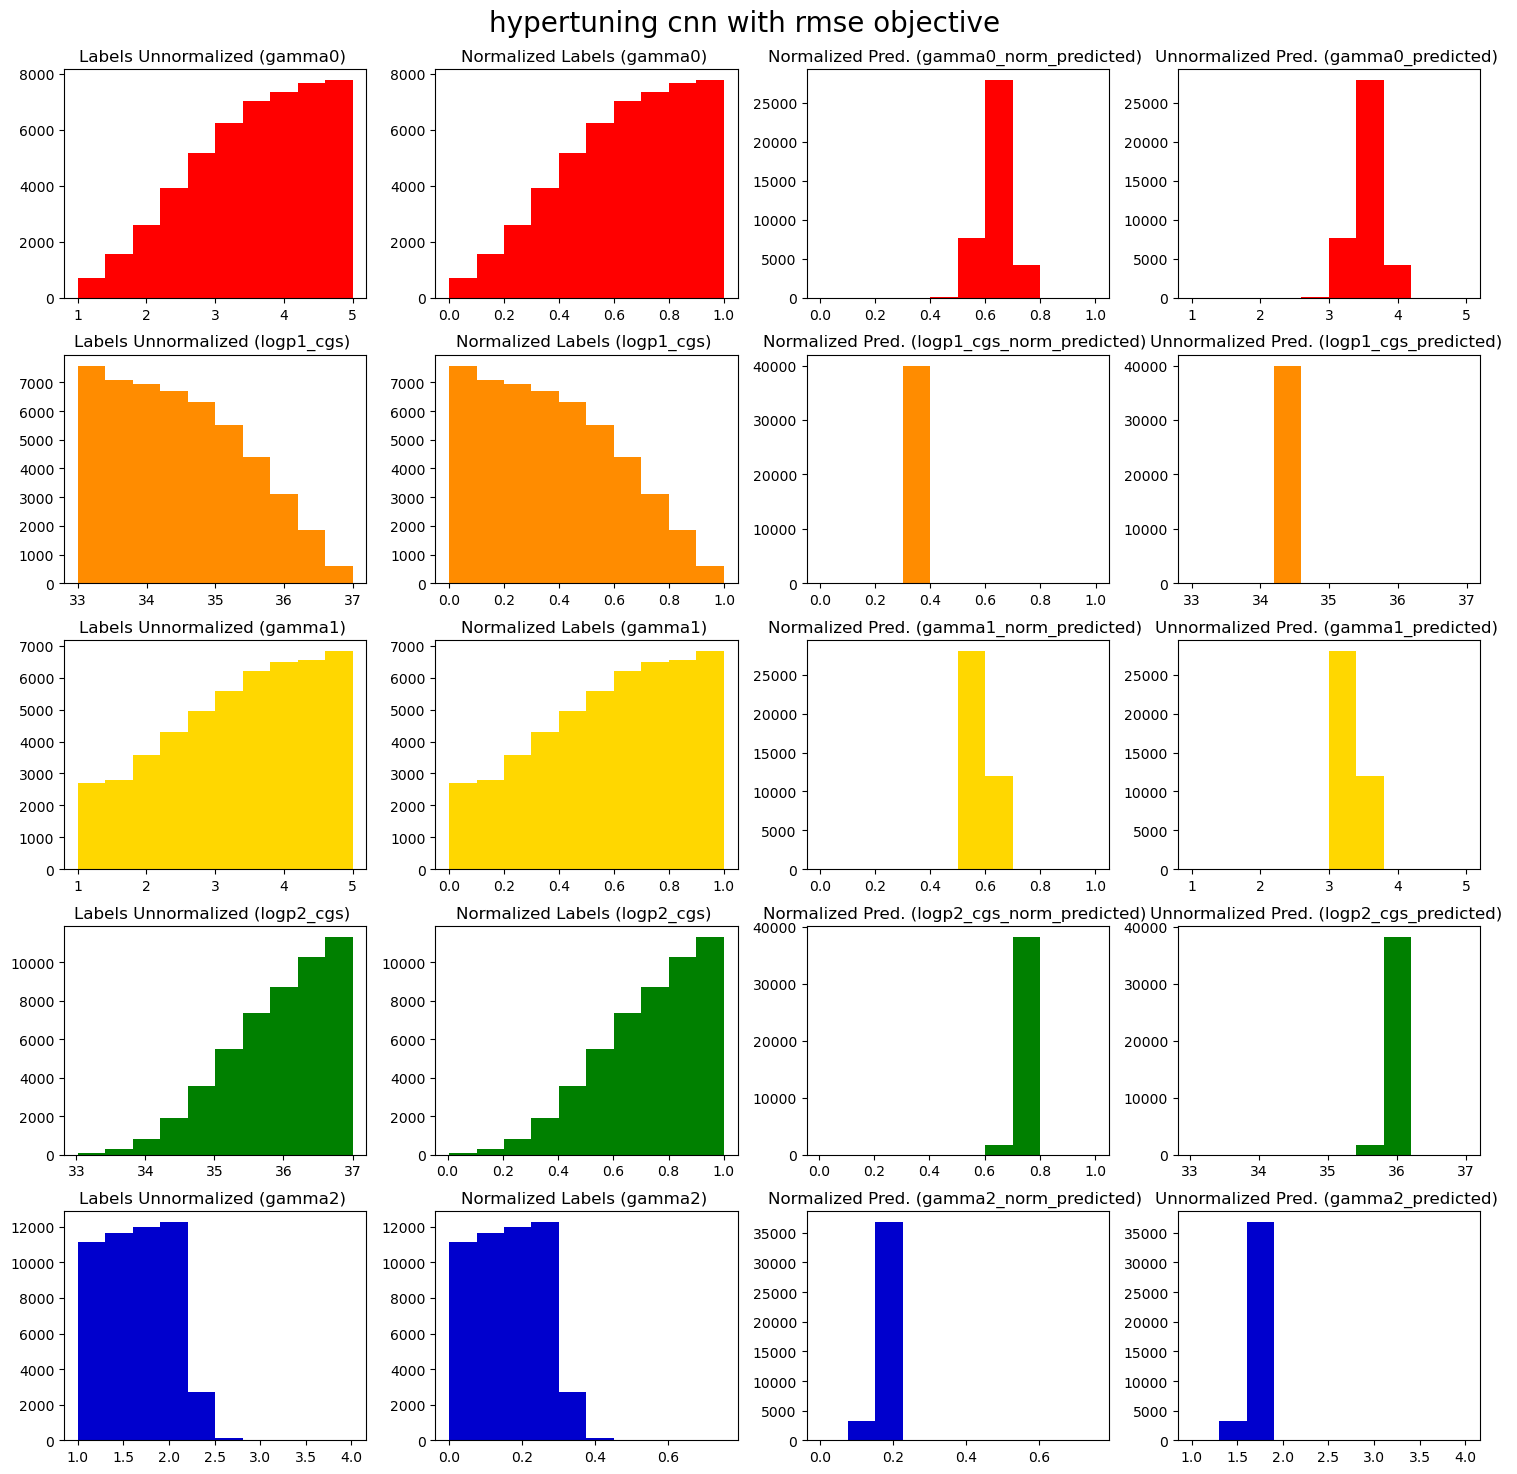

In [21]:
import numpy as np
import matplotlib.pyplot as plt

labels_cols = ['gamma0', 'logp1_cgs', 'gamma1', 'logp2_cgs', 'gamma2']
norm_labels = ['gamma0', 'logp1_cgs', 'gamma1', 'logp2_cgs', 'gamma2']

norm_predictions = ['gamma0_norm_predicted', 'logp1_cgs_norm_predicted', 'gamma1_norm_predicted', 'logp2_cgs_norm_predicted', 'gamma2_norm_predicted']
predictions_cols = ['gamma0_predicted', 'logp1_cgs_predicted', 'gamma1_predicted', 'logp2_cgs_predicted', 'gamma2_predicted']


labels = [df[col].to_numpy() for col in labels_cols]
normlabel = [normeddata[col].to_numpy() for col in norm_labels]

normpredictions = [predictions[col].to_numpy() for col in norm_predictions]
prediction = [predictions[col].to_numpy() for col in predictions_cols]


fig, axs = plt.subplots(5, 4, figsize=(15, 15))

for i in range(5):
    for j in range(4):
        if j == 0:  #first column i want to be gamma0_labels
            color = 'red' if i == 0 else 'darkorange' if i == 1 else 'gold' if i == 2 else 'green' if i == 3 else 'mediumblue'
            axs[i, j].hist(labels[i], color=color, range=(np.min(labels[i]), np.max(labels[i])))
            axs[i, j].set_title(f"Labels Unnormalized ({labels_cols[i]}) ")
            
        elif j == 1:  #second column should be the gamm0 predictions

            color = 'red' if i == 0 else 'darkorange' if i == 1 else 'gold' if i == 2 else 'green' if i == 3 else 'mediumblue'
            axs[i, j].hist(normlabel[i], color=color, range=(np.min(normlabel[i]), np.max(normlabel[i])))
            axs[i, j].set_title(f"Normalized Labels ({norm_labels[i]}) ")
    
          
        elif j == 2:  #3rd column should be the norm labels 
            color = 'red' if i == 0 else 'darkorange' if i == 1 else 'gold' if i == 2 else 'green' if i == 3 else 'mediumblue'
            axs[i, j].hist(normpredictions[i], color=color,range=(np.min(normlabel[i]), np.max(normlabel[i])))
            axs[i, j].set_title(f"Normalized Pred. ({norm_predictions[i]}) ")
            
        
        elif j == 3: # 4th column should be the norm predictions

            color = 'red' if i == 0 else 'darkorange' if i == 1 else 'gold' if i == 2 else 'green' if i == 3 else 'mediumblue'
            axs[i, j].hist(prediction[i], color=color, range=(np.min(labels[i]), np.max(labels[i])))
            axs[i, j].set_title(f"Unnormalized Pred. ({predictions_cols[i]}) ")

plt.tight_layout()
plt.subplots_adjust(top=.94) 
fig.suptitle('hypertuning cnn with rmse objective', fontsize=20)
plt.show()